## Fungsi file: Eksplorasi, eksperimen, dan dokumentasi visual

Testing berbagai teknik preprocessing
Visualisasi hasil (before/after cleaning)
Analisis statistik setiap tahap
Dokumentasi dengan markdown cells
Trial & error parameter (misal: min_df, max_df untuk vectorizer)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from pathlib import Path
from tqdm import tqdm

# Sastrawi for Indonesian NLP
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [2]:
# NLTK for additional text processing
import nltk
try:
    nltk.download('punkt', quiet=True)
except:
    print("NLTK download skipped")

In [3]:
# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Enable tqdm for pandas
tqdm.pandas()

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
# Path ke dataset
data_path = Path('../data/raw/Indo-Online Health Consultation-Multilabel-Raw.csv')

# Load data
print(f"Loading dataset from: {data_path}")
df = pd.read_csv(data_path)

print(f"Dataset loaded successfully!")
print(f"Original Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset from: ..\data\raw\Indo-Online Health Consultation-Multilabel-Raw.csv
Dataset loaded successfully!
Original Shape: 497,974 rows × 10 columns
Memory Usage: 1179.89 MB


### Smart Deduplication

In [5]:
print("DEDUPLICATION PROCESS")
print("="*70)

# Original count
original_count = len(df)
print(f"\n Original dataset: {original_count:,} rows")

# Check exact duplicates (question + answer)
exact_duplicates = df.duplicated(subset=['title', 'question', 'answer']).sum()
print(f" Exact duplicates (Q+A same): {exact_duplicates:,} ({exact_duplicates/original_count*100:.2f}%)")

# Remove exact duplicates
df_clean = df.drop_duplicates(subset=['title', 'question', 'answer'], keep='first')
after_dedup_count = len(df_clean)
removed_count = original_count - after_dedup_count

print(f"\n After removing exact duplicates: {after_dedup_count:,} rows")
print(f"Removed: {removed_count:,} rows ({removed_count/original_count*100:.2f}%)")

# Analyze remaining multi-answer questions
same_q_counts = df_clean.groupby(['title', 'question']).size()
multi_answer_questions = same_q_counts[same_q_counts > 1]

print(f"\n Questions with multiple answers: {len(multi_answer_questions):,}")
print(f"Total rows for multi-answer questions: {multi_answer_questions.sum():,}")

# Add answer count metadata
answer_counts = df_clean.groupby(['title', 'question']).size().rename('answer_count')
df_clean = df_clean.merge(answer_counts, on=['title', 'question'], how='left')

print(f"\n Added 'answer_count' column to track multiple perspectives")

DEDUPLICATION PROCESS

 Original dataset: 497,974 rows
 Exact duplicates (Q+A same): 137,452 (27.60%)

 After removing exact duplicates: 360,522 rows
Removed: 137,452 rows (27.60%)

 Questions with multiple answers: 1,291
Total rows for multi-answer questions: 2,593

 Added 'answer_count' column to track multiple perspectives


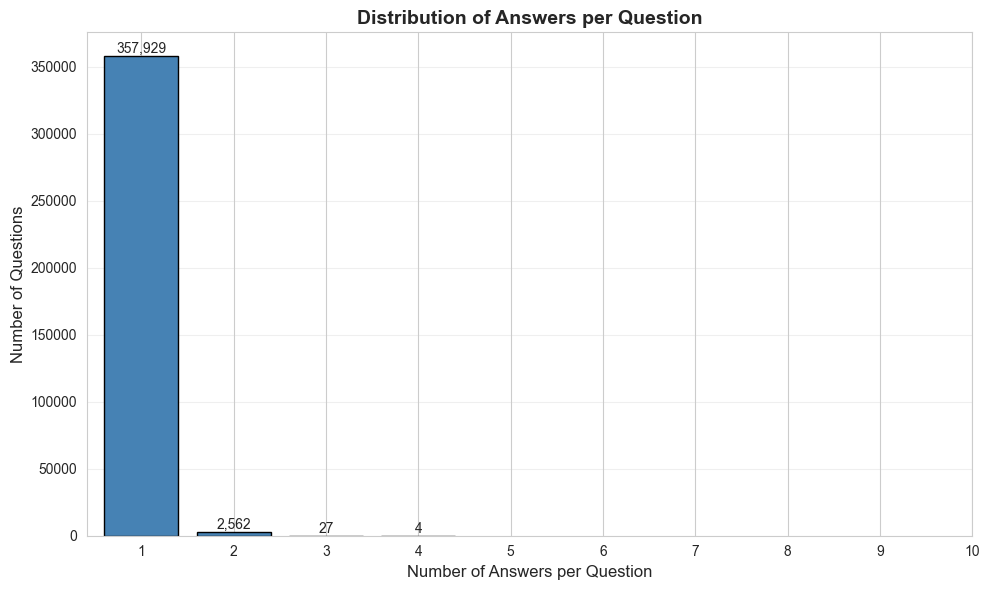


 Top 5 most answered questions:
1. (4 answers) Mengatasi warna kulit wajah yang gelap akibat pemakaian obat...
2. (3 answers) asfiksia...
3. (3 answers) pegal pegal di leher dan di pundak...
4. (3 answers) Benjolan di payudara masih ada pasca operasi...
5. (3 answers) Sakit perut bagian bawah pada laki-laki...


In [6]:
# Visualize answer count distribution
plt.figure(figsize=(10, 6))
answer_dist = df_clean['answer_count'].value_counts().sort_index()
plt.bar(answer_dist.index[:10], answer_dist.values[:10], color='steelblue', edgecolor='black')
plt.xlabel('Number of Answers per Question', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.title('Distribution of Answers per Question', fontsize=14, fontweight='bold')
plt.xticks(range(1, 11))
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (idx, val) in enumerate(zip(answer_dist.index[:10], answer_dist.values[:10])):
    plt.text(idx, val, f'{val:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n Top 5 most answered questions:")
top_answered = df_clean.groupby(['title', 'question']).size().sort_values(ascending=False).head()
for i, (q, count) in enumerate(top_answered.items(), 1):
    print(f"{i}. ({count} answers) {q[0][:80]}...")

### Text Combination

In [7]:
print("\n TEXT COMBINATION")
print("="*70)

# Combine title + question
df_clean['full_question'] = df_clean['title'].fillna('') + ' ' + df_clean['question'].fillna('')

# Check combined text length
df_clean['full_question_length'] = df_clean['full_question'].str.len()
df_clean['full_question_word_count'] = df_clean['full_question'].str.split().str.len()

print(f"\n Full Question Statistics:")
print(df_clean['full_question_length'].describe())

# Sample combined text
print(f"\n Sample Combined Text:")
print("="*70)
print(df_clean['full_question'].iloc[0][:300] + "...")


 TEXT COMBINATION

 Full Question Statistics:
count    360522.000000
mean        397.035854
std         291.501770
min          16.000000
25%         231.000000
50%         333.000000
75%         481.000000
max       42023.000000
Name: full_question_length, dtype: float64

 Sample Combined Text:
Khasiat obat zinc sulphate Dok saya mau tanya Anak saya kan kenak fimosis terus d kasih obat zincpro zinc sulphate drops 10mg/ml katanya buat vitamin untuk memperlancar BAKnya. La terus tak baca kok malah obat itu buat anak diare ya dok. Pdahal anak saya kmaren sebelum priksa 4 hari tidak bAB...


### Text Cleaning

In [8]:
print("\n TEXT CLEANING")
print("="*70)

def clean_text(text):
    """
    Clean and normalize text
    
    Steps:
    1. Convert to string (handle NaN)
    2. Lowercase
    3. Remove URLs
    4. Remove emails
    5. Remove mentions (@username)
    6. Remove hashtags
    7. Remove extra whitespace
    8. Remove numbers (optional - keep for now as medical info might need it)
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply cleaning
print("Cleaning 'full_question'...")
df_clean['clean_question'] = df_clean['full_question'].progress_apply(clean_text)

print("\nCleaning 'answer'...")
df_clean['clean_answer'] = df_clean['answer'].progress_apply(clean_text)

print("\n Text cleaning completed!")


 TEXT CLEANING
Cleaning 'full_question'...


100%|██████████| 360522/360522 [00:12<00:00, 29143.83it/s]



Cleaning 'answer'...


100%|██████████| 360522/360522 [00:49<00:00, 7289.02it/s]


 Text cleaning completed!


In [9]:
# Show before/after example
print("\n Before/After Cleaning Example:")
print("="*70)
print("BEFORE:")
print(df_clean['full_question'].iloc[0][:200])
print("\nAFTER:")
print(df_clean['clean_question'].iloc[0][:200])


 Before/After Cleaning Example:
BEFORE:
Khasiat obat zinc sulphate Dok saya mau tanya Anak saya kan kenak fimosis terus d kasih obat zincpro zinc sulphate drops 10mg/ml katanya buat vitamin untuk memperlancar BAKnya. La terus tak baca kok m

AFTER:
khasiat obat zinc sulphate dok saya mau tanya anak saya kan kenak fimosis terus d kasih obat zincpro zinc sulphate drops 10mg/ml katanya buat vitamin untuk memperlancar baknya. la terus tak baca kok m


### Tokenization

In [10]:
print("\n TOKENIZATION")
print("="*70)

def simple_tokenize(text):
    """Simple word tokenization"""
    if pd.isna(text) or text == "":
        return []
    
    # Remove punctuation and split by whitespace
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = text.split()
    
    # Remove empty strings and single characters (optional)
    tokens = [token for token in tokens if len(token) > 1]
    
    return tokens

# Tokenize questions (sample first to see time)
print("Tokenizing questions (sample 1000 rows first)...")
sample_tokens = df_clean['clean_question'].head(1000).apply(simple_tokenize)
print(f"Sample token count: {sample_tokens.str.len().mean():.1f} tokens per question")

# Full tokenization
print("\nTokenizing full dataset...")
df_clean['question_tokens'] = df_clean['clean_question'].progress_apply(simple_tokenize)
df_clean['answer_tokens'] = df_clean['clean_answer'].progress_apply(simple_tokenize)

print("\n Tokenization completed!")

# Token statistics
print("\n Token Statistics:")
print(f"Avg tokens per question: {df_clean['question_tokens'].str.len().mean():.1f}")
print(f"Avg tokens per answer: {df_clean['answer_tokens'].str.len().mean():.1f}")

# Show example
print("\n Tokenization Example:")
print("="*70)
print("Original:", df_clean['clean_question'].iloc[0][:100])
print("\nTokens:", df_clean['question_tokens'].iloc[0][:20])


 TOKENIZATION
Tokenizing questions (sample 1000 rows first)...
Sample token count: 54.6 tokens per question

Tokenizing full dataset...


100%|██████████| 360522/360522 [00:23<00:00, 15556.77it/s]



 Tokenization completed!

 Token Statistics:
Avg tokens per question: 62.2
Avg tokens per answer: 206.2

 Tokenization Example:
Original: khasiat obat zinc sulphate dok saya mau tanya anak saya kan kenak fimosis terus d kasih obat zincpro

Tokens: ['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'saya', 'mau', 'tanya', 'anak', 'saya', 'kan', 'kenak', 'fimosis', 'terus', 'kasih', 'obat', 'zincpro', 'zinc', 'sulphate', 'drops']


### Stopword Removal

In [11]:
print("\n STOPWORD REMOVAL")
print("="*70)

# Initialize Sastrawi stopword remover
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# Get stopword list
stopwords = stopword_factory.get_stop_words()
print(f"Indonesian stopwords count: {len(stopwords)}")
print(f"Sample stopwords: {list(stopwords)[:20]}")

def remove_stopwords(tokens):
    """Remove stopwords from token list"""
    if not tokens:
        return []
    return [token for token in tokens if token not in stopwords]

# Apply stopword removal
print("\nRemoving stopwords from questions...")
df_clean['question_tokens_no_stop'] = df_clean['question_tokens'].progress_apply(remove_stopwords)

print("\nRemoving stopwords from answers...")
df_clean['answer_tokens_no_stop'] = df_clean['answer_tokens'].progress_apply(remove_stopwords)

print("\n Stopword removal completed!")


 STOPWORD REMOVAL
Indonesian stopwords count: 126
Sample stopwords: ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena']

Removing stopwords from questions...


100%|██████████| 360522/360522 [00:30<00:00, 11818.37it/s]



Removing stopwords from answers...


100%|██████████| 360522/360522 [01:25<00:00, 4239.63it/s]



 Stopword removal completed!


In [12]:
# Compare before/after
before_count = df_clean['question_tokens'].str.len().mean()
after_count = df_clean['question_tokens_no_stop'].str.len().mean()
reduction = (before_count - after_count) / before_count * 100

print(f"\n Stopword Removal Impact:")
print(f"Avg tokens before: {before_count:.1f}")
print(f"Avg tokens after: {after_count:.1f}")
print(f"Reduction: {reduction:.1f}%")

# Example
print("\n Before/After Stopword Removal:")
print("="*70)
print("Before:", df_clean['question_tokens'].iloc[0][:15])
print("After:", df_clean['question_tokens_no_stop'].iloc[0][:15])


 Stopword Removal Impact:
Avg tokens before: 62.2
Avg tokens after: 45.1
Reduction: 27.5%

 Before/After Stopword Removal:
Before: ['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'saya', 'mau', 'tanya', 'anak', 'saya', 'kan', 'kenak', 'fimosis', 'terus', 'kasih']
After: ['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'mau', 'tanya', 'anak', 'kan', 'kenak', 'fimosis', 'terus', 'kasih', 'obat', 'zincpro']


### Steaming

In [13]:
print("\n STEMMING")
print("="*70)

# Initialize Sastrawi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stem_tokens(tokens):
    """Stem each token to its root form"""
    if not tokens:
        return []
    return [stemmer.stem(token) for token in tokens]

# Note: Stemming is computationally expensive on large datasets
# We'll use an optimized caching approach for speed

print(" OPTIMIZED STEMMING WITH CACHING")
print("="*70)

# Step 1: Collect all unique words
print("\n Step 1: Collecting unique words...")
all_words = set()

print("Scanning questions...")
for tokens in tqdm(df_clean['question_tokens_no_stop'], desc="Questions"):
    if tokens:
        all_words.update(tokens)

print("Scanning answers...")
for tokens in tqdm(df_clean['answer_tokens_no_stop'], desc="Answers"):
    if tokens:
        all_words.update(tokens)

print(f"\n Found {len(all_words):,} unique words")

# Step 2: Pre-compute stems for all unique words (one-time operation)
print("\n Step 2: Pre-computing stems for unique words...")
stem_cache = {}
for word in tqdm(all_words, desc="Building stem cache"):
    stem_cache[word] = stemmer.stem(word)

print(f"Cache built with {len(stem_cache):,} entries")

# Step 3: Define fast cached stemming function
def stem_tokens_cached(tokens):
    """Stem tokens using pre-built cache (O(1) lookup)"""
    if not tokens:
        return []
    return [stem_cache.get(token, token) for token in tokens]

# Step 4: Apply cached stemming (super fast!)
print("\n Step 3: Applying cached stems...")
print("Processing questions...")
df_clean['question_tokens_stemmed'] = df_clean['question_tokens_no_stop'].progress_apply(stem_tokens_cached)

print("Processing answers...")
df_clean['answer_tokens_stemmed'] = df_clean['answer_tokens_no_stop'].progress_apply(stem_tokens_cached)

print("\n Stemming completed!")

# Show example
print("\n Stemming Example:")
print("="*70)
print("Before:", df_clean['question_tokens_no_stop'].iloc[0][:10])
print("After:", df_clean['question_tokens_stemmed'].iloc[0][:10])

# Show cache efficiency
sample_words = list(all_words)[:5]
print(f"\n Sample Stem Mappings:")
for word in sample_words:
    print(f"  {word} → {stem_cache[word]}")


 STEMMING
 OPTIMIZED STEMMING WITH CACHING

 Step 1: Collecting unique words...
Scanning questions...


Questions: 100%|██████████| 360522/360522 [00:01<00:00, 253112.20it/s]


Scanning answers...


Answers: 100%|██████████| 360522/360522 [00:03<00:00, 92009.68it/s]



 Found 382,874 unique words

 Step 2: Pre-computing stems for unique words...


Building stem cache: 100%|██████████| 382874/382874 [12:12:59<00:00,  8.71it/s]  


Cache built with 382,874 entries

 Step 3: Applying cached stems...
Processing questions...


100%|██████████| 360522/360522 [00:07<00:00, 45581.26it/s] 


Processing answers...


100%|██████████| 360522/360522 [00:12<00:00, 28697.59it/s]



 Stemming completed!

 Stemming Example:
Before: ['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'mau', 'tanya', 'anak', 'kan', 'kenak']
After: ['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'mau', 'tanya', 'anak', 'kan', 'nak']

 Sample Stem Mappings:
  munurunya → munurunya
  mewarisinya → waris
  erichati → erichati
  sidhiq → sidhiq
  hirsutism → hirsutism


### Create Processed Text Strings

In [14]:
print("\n CREATING PROCESSED TEXT STRINGS")
print("="*70)

# Join tokens back to strings
df_clean['processed_question'] = df_clean['question_tokens_stemmed'].apply(lambda x: ' '.join(x) if x else '')
df_clean['processed_answer'] = df_clean['answer_tokens_stemmed'].apply(lambda x: ' '.join(x) if x else '')

# Calculate processed text length
df_clean['processed_question_length'] = df_clean['processed_question'].str.len()
df_clean['processed_answer_length'] = df_clean['processed_answer'].str.len()

print("Processed text strings created!")

# Statistics
print("\n Processed Text Statistics:")
print(f"Avg processed question length: {df_clean['processed_question_length'].mean():.0f} chars")
print(f"Avg processed answer length: {df_clean['processed_answer_length'].mean():.0f} chars")

# Show transformation pipeline
print("\n Full Preprocessing Pipeline Example:")
print("="*70)
idx = 0
print(f"1. ORIGINAL QUESTION:\n{df_clean['full_question'].iloc[idx][:200]}...\n")
print(f"2. CLEANED:\n{df_clean['clean_question'].iloc[idx][:200]}...\n")
print(f"3. TOKENS (first 15):\n{df_clean['question_tokens'].iloc[idx][:15]}\n")
print(f"4. NO STOPWORDS (first 15):\n{df_clean['question_tokens_no_stop'].iloc[idx][:15]}\n")
print(f"5. STEMMED (first 15):\n{df_clean['question_tokens_stemmed'].iloc[idx][:15]}\n")
print(f"6. FINAL PROCESSED:\n{df_clean['processed_question'].iloc[idx][:200]}...")


 CREATING PROCESSED TEXT STRINGS
Processed text strings created!

 Processed Text Statistics:
Avg processed question length: 266 chars
Avg processed answer length: 938 chars

 Full Preprocessing Pipeline Example:
1. ORIGINAL QUESTION:
Khasiat obat zinc sulphate Dok saya mau tanya Anak saya kan kenak fimosis terus d kasih obat zincpro zinc sulphate drops 10mg/ml katanya buat vitamin untuk memperlancar BAKnya. La terus tak baca kok m...

2. CLEANED:
khasiat obat zinc sulphate dok saya mau tanya anak saya kan kenak fimosis terus d kasih obat zincpro zinc sulphate drops 10mg/ml katanya buat vitamin untuk memperlancar baknya. la terus tak baca kok m...

3. TOKENS (first 15):
['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'saya', 'mau', 'tanya', 'anak', 'saya', 'kan', 'kenak', 'fimosis', 'terus', 'kasih']

4. NO STOPWORDS (first 15):
['khasiat', 'obat', 'zinc', 'sulphate', 'dok', 'mau', 'tanya', 'anak', 'kan', 'kenak', 'fimosis', 'terus', 'kasih', 'obat', 'zincpro']

5. STEMMED (first 15):


### Data Quality Check After Preprocessing

In [15]:
print("\n POST-PREPROCESSING QUALITY CHECK")
print("="*70)

# Check for empty processed texts
empty_questions = (df_clean['processed_question'].str.len() == 0).sum()
empty_answers = (df_clean['processed_answer'].str.len() == 0).sum()

print(f"\n Empty processed questions: {empty_questions} ({empty_questions/len(df_clean)*100:.2f}%)")
print(f"Empty processed answers: {empty_answers} ({empty_answers/len(df_clean)*100:.2f}%)")

# Filter out empty processed texts if any
if empty_questions > 0 or empty_answers > 0:
    before_filter = len(df_clean)
    df_clean = df_clean[
        (df_clean['processed_question'].str.len() > 0) & 
        (df_clean['processed_answer'].str.len() > 0)
    ]
    after_filter = len(df_clean)
    print(f"\n  Removed {before_filter - after_filter} rows with empty processed text")

# Final statistics
print(f"\n Final cleaned dataset: {len(df_clean):,} rows")


 POST-PREPROCESSING QUALITY CHECK

 Empty processed questions: 0 (0.00%)
Empty processed answers: 9 (0.00%)

  Removed 9 rows with empty processed text

 Final cleaned dataset: 360,513 rows


### Visualization: Text Length Distribution


 TEXT LENGTH DISTRIBUTIONS


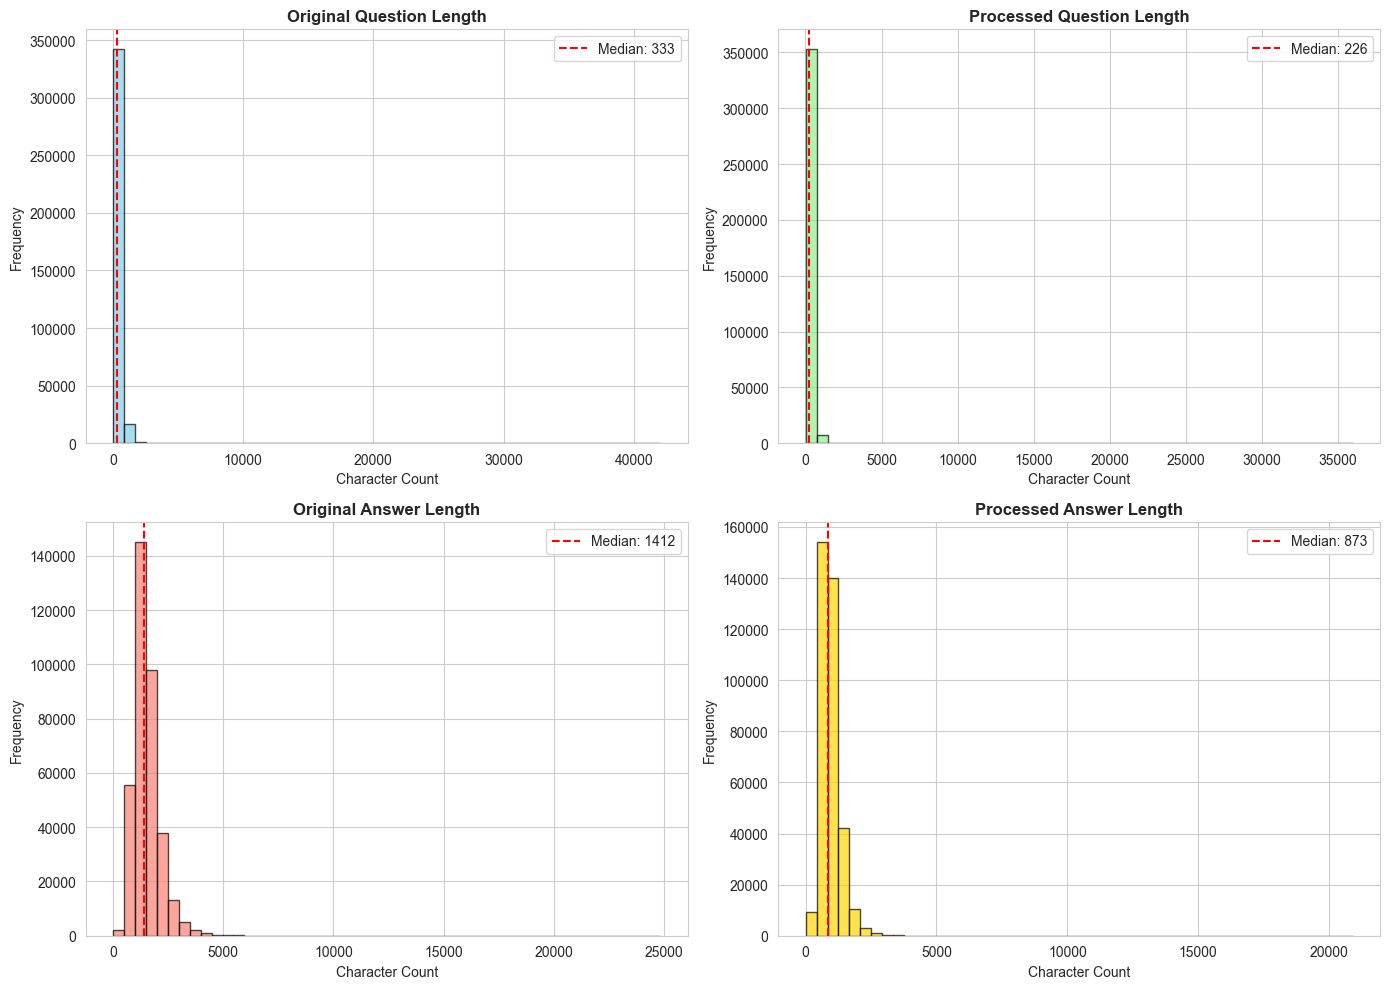

In [17]:
print("\n TEXT LENGTH DISTRIBUTIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original question length
axes[0, 0].hist(df_clean['full_question_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_clean['full_question_length'].median(), color='red', linestyle='--', 
                   label=f"Median: {df_clean['full_question_length'].median():.0f}")
axes[0, 0].set_title('Original Question Length', fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Processed question length
axes[0, 1].hist(df_clean['processed_question_length'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_clean['processed_question_length'].median(), color='red', linestyle='--',
                   label=f"Median: {df_clean['processed_question_length'].median():.0f}")
axes[0, 1].set_title('Processed Question Length', fontweight='bold')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Create answer_length column if it doesn't exist
if 'answer_length' not in df_clean.columns:
    df_clean['answer_length'] = df_clean['answer'].str.len()

# Original answer length
axes[1, 0].hist(df_clean['answer_length'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df_clean['answer_length'].median(), color='red', linestyle='--',
                   label=f"Median: {df_clean['answer_length'].median():.0f}")
axes[1, 0].set_title('Original Answer Length', fontweight='bold')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Processed answer length
axes[1, 1].hist(df_clean['processed_answer_length'], bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df_clean['processed_answer_length'].median(), color='red', linestyle='--',
                   label=f"Median: {df_clean['processed_answer_length'].median():.0f}")
axes[1, 1].set_title('Processed Answer Length', fontweight='bold')
axes[1, 1].set_xlabel('Character Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Create Development Samples

In [18]:
print("\n CREATING DEVELOPMENT SAMPLES")
print("="*70)

# Check if we have topic_set for stratification
if 'topic_set' in df_clean.columns:
    stratify_col = 'topic_set'
    print(f"Using stratified sampling by: {stratify_col}")
else:
    stratify_col = None
    print("Using random sampling (no stratification)")

# Sample sizes
sample_configs = {
    '1pct': 0.01,
    '5pct': 0.05,
    '10pct': 0.10
}

samples = {}

for name, frac in sample_configs.items():
    if stratify_col:
        # Stratified sampling
        sample = df_clean.groupby(stratify_col, group_keys=False).apply(
            lambda x: x.sample(frac=frac, random_state=42) if len(x) > 1 else x
        )
    else:
        # Random sampling
        sample = df_clean.sample(frac=frac, random_state=42)
    
    samples[name] = sample
    print(f" Created {name} sample: {len(sample):,} rows ({frac*100:.1f}%)")

# Verify topic distribution in samples (if applicable)
if stratify_col:
    print(f"\n Topic Distribution Verification (top 5 topics):")
    print("="*70)
    
    full_dist = df_clean[stratify_col].value_counts(normalize=True).head()
    sample_dist = samples['5pct'][stratify_col].value_counts(normalize=True).head()
    
    comparison = pd.DataFrame({
        'Full Dataset': full_dist,
        '5% Sample': sample_dist
    })
    print(comparison)


 CREATING DEVELOPMENT SAMPLES
Using stratified sampling by: topic_set
 Created 1pct sample: 3,686 rows (1.0%)
 Created 5pct sample: 18,108 rows (5.0%)
 Created 10pct sample: 36,152 rows (10.0%)

 Topic Distribution Verification (top 5 topics):
              Full Dataset  5% Sample
topic_set                            
kehamilan         0.035682   0.035509
menstruasi        0.030584   0.030429
obat              0.019883   0.019770
bayi              0.017816   0.017727
intim-wanita      0.015919   0.015849


### Save Processed Data

In [19]:
print("\n SAVING PROCESSED DATA")
print("="*70)

# Create processed directory
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# Select columns to save
columns_to_save = [
    # Original columns
    'title', 'question', 'answer', 'question_date', 'answer_date',
    'topics', 'topic_set', 'risk', 'year', 'time_to_answer',
    
    # Processed columns
    'full_question', 'clean_question', 'clean_answer',
    'processed_question', 'processed_answer',
    
    # Metadata
    'answer_count',
    
    # Length statistics
    'full_question_length', 'answer_length',
    'processed_question_length', 'processed_answer_length'
]

# Save full processed dataset
print("\n1. Saving full processed dataset...")
full_path = processed_dir / 'processed_full.csv'
df_clean[columns_to_save].to_csv(full_path, index=False)
print(f"Saved to: {full_path}")
print(f"Rows: {len(df_clean):,}")
print(f"Size: {full_path.stat().st_size / 1024**2:.2f} MB")

# Save sample datasets
for name, sample_df in samples.items():
    print(f"\n2. Saving {name} sample...")
    sample_path = processed_dir / f'processed_{name}.csv'
    sample_df[columns_to_save].to_csv(sample_path, index=False)
    print(f"Saved to: {sample_path}")
    print(f"Rows: {len(sample_df):,}")
    print(f"Size: {sample_path.stat().st_size / 1024**2:.2f} MB")

# Save preprocessing summary
print("\n3. Saving preprocessing summary...")
summary = {
    'original_rows': original_count,
    'after_deduplication': after_dedup_count,
    'removed_duplicates': removed_count,
    'final_rows': len(df_clean),
    'multi_answer_questions': len(multi_answer_questions),
    'avg_question_length_original': df_clean['full_question_length'].mean(),
    'avg_question_length_processed': df_clean['processed_question_length'].mean(),
    'avg_answer_length_original': df_clean['answer_length'].mean(),
    'avg_answer_length_processed': df_clean['processed_answer_length'].mean(),
    'stopwords_count': len(stopwords),
    'sample_1pct_rows': len(samples['1pct']),
    'sample_5pct_rows': len(samples['5pct']),
    'sample_10pct_rows': len(samples['10pct']),
}

import json
summary_path = processed_dir / 'preprocessing_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Saved to: {summary_path}")

print("\n" + "="*70)
print("ALL DATA SAVED SUCCESSFULLY!")
print("="*70)


 SAVING PROCESSED DATA

1. Saving full processed dataset...
Saved to: ..\data\processed\processed_full.csv
Rows: 360,513
Size: 1903.92 MB

2. Saving 1pct sample...
Saved to: ..\data\processed\processed_1pct.csv
Rows: 3,686
Size: 19.46 MB

2. Saving 5pct sample...
Saved to: ..\data\processed\processed_5pct.csv
Rows: 18,108
Size: 95.49 MB

2. Saving 10pct sample...
Saved to: ..\data\processed\processed_10pct.csv
Rows: 36,152
Size: 190.84 MB

3. Saving preprocessing summary...
Saved to: ..\data\processed\preprocessing_summary.json

ALL DATA SAVED SUCCESSFULLY!
